# MTH5 Example 04

## RunTS Object

`mth5.timeseries.RunTS` is a container to hold multiple synchronous channels of the same sampling rate.  The data is contained in an `xarray.DataSet` which is a collection of `ChannelTS.to_xarray()` objects.

To get a `RunTS` object from an MTH5:

```
run_group = mth5_object.get_run("station", "run_id", survey="survey")
run_ts_object = run_group.to_runts()
```

In [1]:
%matplotlib inline
import numpy as np
from mth5.timeseries import ChannelTS, RunTS
from mt_metadata.timeseries import Electric, Magnetic, Auxiliary, Run, Station

## Create a Run 

We will create a common run that has all 5 channels of an MT measurement (Hx, Hy, Hz, Ex, Ey) plus an auxiliary channel.  We will make individual channels first and then add them into a `RunTS` object. 

In [2]:
channel_list = []
common_start = "2020-01-01T00:00:00"
sample_rate = 8.0
n_samples = 4096
t = np.arange(n_samples)
data = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 3, 20), np.random.rand(20))], axis=0)

station_metadata = Station(id="mt001")
run_metadata = Run(id="001")

### Create `magnetic` channels

In [3]:
for component in ["hx", "hy", "hz"]:
    h_metadata = Magnetic(component=component)
    h_metadata.time_period.start = common_start
    h_metadata.sample_rate = sample_rate
    h_channel = ChannelTS(
        channel_type="magnetic",
        data=data,
        channel_metadata=h_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
    channel_list.append(h_channel)
    

### Create `electric` channels

In [4]:
for component in ["ex", "ey"]:
    e_metadata = Electric(component=component)
    e_metadata.time_period.start = common_start
    e_metadata.sample_rate = sample_rate
    e_channel = ChannelTS(
        channel_type="electric",
        data=data,
        channel_metadata=e_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
    channel_list.append(e_channel)

### Create `auxiliary` channel

In [5]:
aux_metadata = Auxiliary(component="temperature")
aux_metadata.time_period.start = common_start
aux_metadata.sample_rate = sample_rate
aux_channel = ChannelTS(
        channel_type="auxiliary",
        data=np.random.rand(n_samples) * 30,
        channel_metadata=aux_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
channel_list.append(aux_channel)

## Create `RunTS` object

Now that we have made individual channels we can make a `RunTS` object by inputing a list of `ChannelTS` objects. 

**Note**: This can also be a list of `xarray.DataArray` objects formated like a channel.

In [6]:
run = RunTS(channel_list)

In [7]:
run

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:08:31.875000+00:00
	Sample Rate: 8.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

## Plot Run
Again this is a hack at the moment, we are working on a better visualization, but this works for now.

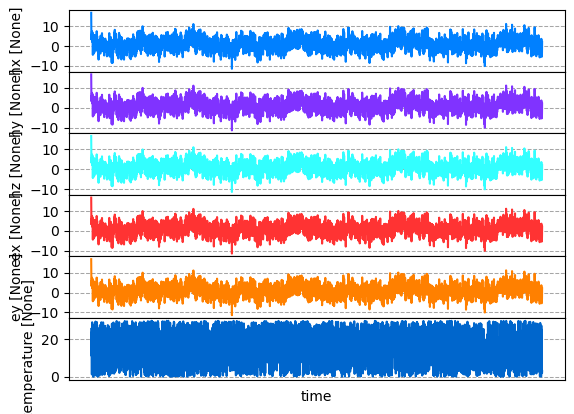

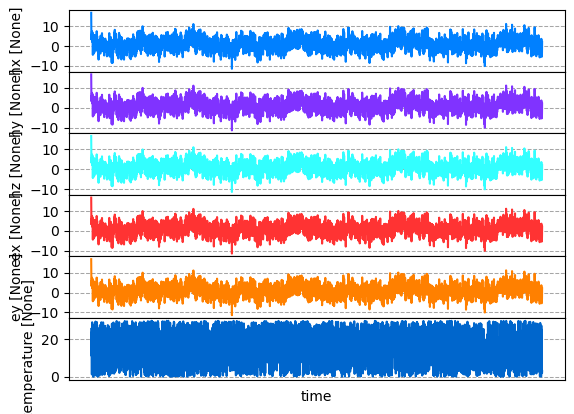

In [8]:
run.plot()

## Calibration

a `RunTS` object can also be calibrate, it is a convenience function that calls `remove_instrument_response` on each channel.  

See Example 5 for a working example.

```
calibrated_run = run_ts_object.calibrate()
```

## Combine Runs

As with `ChannelTS` multiple `RunTS` objects can be added together.  Gaps by default are filled with median values of the end points.  

First the time index is developed from the runs so that it is monotonic, then data is filled in with the runs, then gaps are filled.

In [9]:
for ch in channel_list:
    ch.start = ch.end + 1
run_02 = RunTS(channel_list)

In [10]:
run_02

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:08:32.875000+00:00
	End:         2020-01-01T00:17:04.750000+00:00
	Sample Rate: 8.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

In [11]:
run_03 = run + run_02

2023-11-14T09:43:58.247562+1100 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-01-01T00:17:04.750000+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:17:04.750000+00:00


In [12]:
run_03

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:17:04.750000+00:00
	Sample Rate: 8.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

## Interpolate and Resample

A common time series transformation is interpolation and resampling. Here we will use scipy.interpolate.resample_poly for an efficient and more accurate interpolation especially at the ends of the time series.

There are methods for 

- `resample`: does not apply an antialias filter
- `decimate` applies an antialias filter, but assumes a periodic signal and can have edge effects.
- `resample_poly`: applies an antialias filter and does not assume a periodic signal is more efficient and accurate.  

In [13]:
interpolated_run = run_03.resample_poly(1)

2023-11-14T09:43:58.437763+1100 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-01-01T00:17:04+00:00 does not match metadata end 2020-01-01T00:17:04.750000+00:00 updating metatdata value to 2020-01-01T00:17:04+00:00


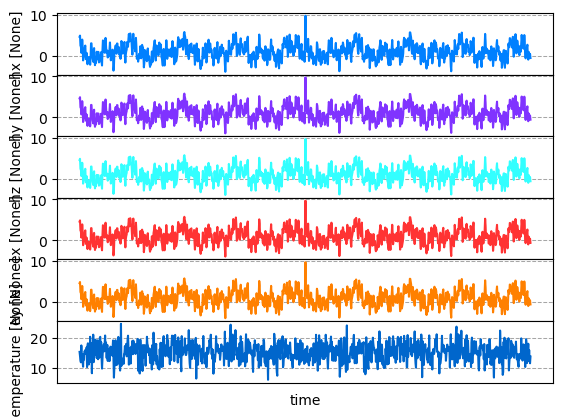

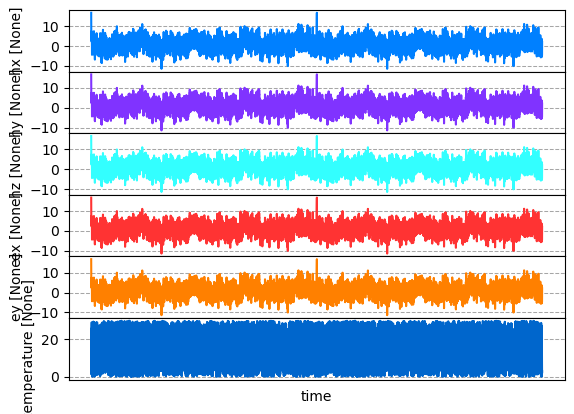

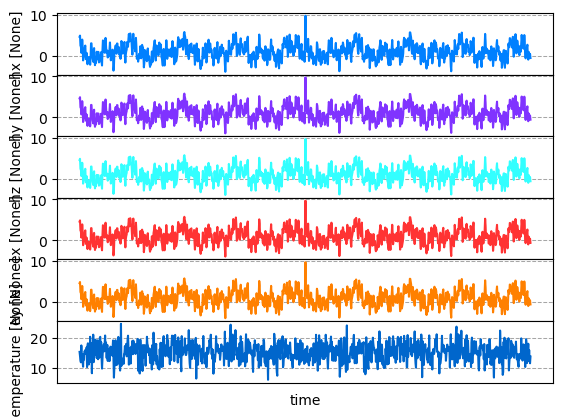

In [14]:
run_03.plot(); interpolated_run.plot()